In [18]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

2.2.2+cpu


In [2]:
def get_batch(batch_size: int,
              chw: tuple[int, int]=(3, 10, 10),
              seq_len: int=10) -> torch.Tensor:
    x = torch.randn((batch_size, seq_len, *chw))
    y = torch.cumsum(x, dim=1)
    
    return x, y

In [3]:
class ConvLSTMCell(nn.Module):
    """Implementation based on the paper: Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting (https://arxiv.org/abs/1506.04214)."""
    def __init__(self, 
                 in_shape: tuple[int, int, int],
                 out_channels: int,
                 kernel_size: int,
                 activation: str='tanh'):
        """The constructor of the ConvLSTM cell. The cell is supposed to act similarly to the default nn.LSTM cell, but with convolutional layers instead of linear layers.
        
        :param in_shape: The shape of the input tensor (in_channels, height, width).
        :param out_channels: The number of output channels of the cell.
        :param kernel_size: The size of the convolutional kernel.
        :param activation: The activation function of the cell. Can be either 'relu' or 'tanh'.
        """
        super(ConvLSTMCell, self).__init__()

        assert activation in ["relu", "tanh"], "Activation must be either 'relu' or 'tanh'."
        assert kernel_size % 2 == 1, "Kernel size must be odd."

        if activation == "tanh": self.activation = torch.tanh 
        elif activation == "relu": self.activation = torch.relu

        # Single convolutional layer will do all calculations in parallel
        self.conv = nn.Conv2d(in_channels=in_shape[0] + out_channels, 
                              out_channels=4 * out_channels, 
                              kernel_size=kernel_size, 
                              padding=kernel_size // 2)  

        # The biases for the gates
        self.W_ci = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))
        self.W_co = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))
        self.W_cf = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))

    def forward(self, x: torch.Tensor, h_prev: torch.Tensor, c_prev: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """The forward pass of the ConvLSTM cell. The ConvLSTM is supposed to act similarly to the 
        default nn.LSTM cell, but with convolutional layers instead of linear layers.

        :param x: The input tensor of shape (batch_size, in_channels, height, width).
        :param h_prev: The hidden state of the previous time step. (batch_size, out_channels, height, width)
        :param c_prev: The cell state of the previous time step. (batch_size, out_channels, height, width)

        :return: (ct, ht) The cell state and the hidden state of the current time step. Both are of shape (batch_size, out_channels, height, width).
        """
        # Concatenate the input tensor with the hidden state along the channel dimension
        xh = torch.cat([x, h_prev], dim=1) # (batch_size, in_channels + out_channels, height, width)
        # Put the concatenated tensor through the convolutional layer
        # NOTE: The output of the convolutional layer is split into 4 parts: input gate, forget gate, cell state, output gate (the output channels of the conv is 4 * out_channels)
        i_conv, f_conv, C_conv, o_conv = torch.chunk(self.conv(xh), chunks=4, dim=1) # each element is of shape (batch_size, out_channels, height, width)

        it = torch.sigmoid(i_conv + self.W_ci * c_prev) # (batch_size, out_channels, height, width)
        ft = torch.sigmoid(f_conv + self.W_cf * c_prev) # (batch_size, out_channels, height, width)
        ct = ft * c_prev + it * self.activation(C_conv) # (batch_size, out_channels, height, width)
        ot = torch.sigmoid(o_conv + self.W_co * ct) # (batch_size, out_channels, height, width)
        ht = ot * self.activation(ct) # (batch_size, out_channels, height, width)

        return ht, ct

class ConvLSTM(nn.Module):
    def __init__(self, 
                 in_shape: tuple[int, int, int], 
                 out_channels: int, 
                 kernel_size: int, 
                 activation: str='tanh'):
        """The constructor of the ConvLSTM layer. The layer is supposed to act similarly to the default nn.LSTM cell, but with convolutional layers instead of linear layers.
        
        :param in_shape: The shape of the input tensor (in_channels, height, width).
        :param out_channels: The number of output channels of the cell.
        :param kernel_size: The size of the convolutional kernel.
        :param activation: The activation function of the cell. Can be either 'relu' or 'tanh'.
        """
        super(ConvLSTM, self).__init__()
        self.out_channels = out_channels
        self.cell = ConvLSTMCell(in_shape, out_channels, kernel_size, activation)

    def forward(self, x: torch.Tensor, h0c0: tuple[torch.Tensor, torch.Tensor]=None) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        """The forward pass of the ConvLSTM cell. The ConvLSTM is supposed to act similarly to the PyTorch nn.LSTM layer, but with convolutional layers instead of linear layers.
        
        :param x: The input tensor of shape (batch_size, seq_len, in_channels, height, width).
        :param h0c0: The initial hidden and cell states. Both are of shape (batch_size, out_channels, height, width). If None, the initial states are set to zeros.

        :return: output, (h_n, c_n) where:
            - output: The output tensor of shape (batch_size, seq_len, out_channels, height, width).
            - h_n: The hidden state of the last time step. (batch_size, out_channels, height, width).
            - c_n: The cell state of the last time step. (batch_size, out_channels, height, width).
        """
        batch_size, seq_len, _, height, width = x.shape
        if h0c0 is None:
            h0 = torch.zeros(batch_size, self.out_channels, height, width)
            c0 = torch.zeros(batch_size, self.out_channels, height, width)
        else:
            h0, c0 = h0c0
        
        h = h0
        c = c0
        output = []
        for t in range(seq_len):
            h, c = self.cell(x[:, t], h, c)
            output.append(h)
        
        return torch.stack(output, dim=1), (h, c)

class Model(nn.Module):
    def __init__(self, hidden_dim: int, out_channels: int):
        super(Model, self).__init__()
        self.out_channels = out_channels
        self.lstm = ConvLSTM((3, 10, 10), hidden_dim, 3)
        self.conv = nn.Conv2d(hidden_dim, out_channels, kernel_size=1)
    
    def forward(self, x, target=None):
        h, _ = self.lstm(x) # (batch_size, seq_len, hidden_dim, height, width)
        # NOTE: PyTorch doesn't accept the shape (batch_size, seq_len, channels, height, width) for the convolutional layer, so we need to reshape the tensor
        h = h.view(-1, *h.shape[2:])
        y = self.conv(h).view(x.shape[0], x.shape[1], self.out_channels, x.shape[-2], x.shape[-1])

        if target is not None:
            loss = nn.MSELoss()(y, target)
            return y, loss
        else: 
            return y, None

In [4]:
model = Model(12, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 10167


In [6]:
# Training loop
total_loss = 0

for i in tqdm(range(5000)):
    x, y = get_batch(64, (3, 10, 10), 10)
    optimizer.zero_grad(set_to_none=True)
    y_pred, loss = model(x, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    if i % 500 == 499:
        print(f"Epoch {i} - Loss: {total_loss / 100}")
        total_loss = 0

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 499 - Loss: 1.8405342466570438
Epoch 999 - Loss: 0.131025272635743
Epoch 1499 - Loss: 0.08011881412006915
Epoch 1999 - Loss: 0.04966027318034321
Epoch 2499 - Loss: 0.03723904399899766
Epoch 2999 - Loss: 0.02974683761363849
Epoch 3499 - Loss: 0.02270903545897454
Epoch 3999 - Loss: 0.018880759921157734
Epoch 4499 - Loss: 0.016389821426710114
Epoch 4999 - Loss: 0.013328103617532179


In [7]:
with torch.no_grad():
    x, y = get_batch(1, (3, 10, 10), 10)
    y_pred, _ = model(x)

    print("GT:", y.view(-1)[:10])
    print("Pred:", y_pred.view(-1)[:10])

    print("Loss:", nn.MSELoss()(y_pred, y).item())
    print("Max difference:", (y_pred - y).abs().max().item())

GT: tensor([ 0.7221,  0.1624,  0.1510, -0.2192, -1.2814, -1.5578, -0.0467, -0.2113,
        -0.6158, -0.6061])
Pred: tensor([ 0.7203,  0.1690,  0.1586, -0.2081, -1.2842, -1.5572, -0.0433, -0.1949,
        -0.6182, -0.5940])
Loss: 0.0012540235184133053
Max difference: 0.18154525756835938


Text(0.5, 1.0, 'GT3')

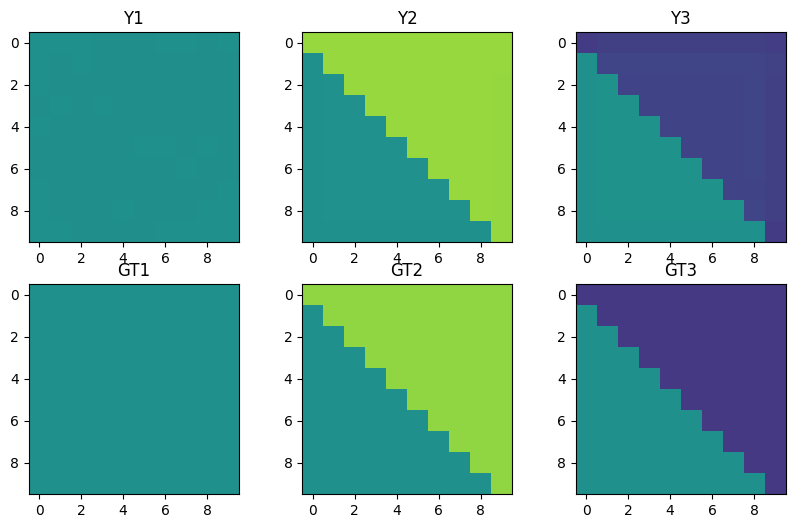

In [37]:
hc = None

with torch.no_grad():
    x = torch.zeros((1, 1, 3, 10, 10))
    gt1 = x.clone()

    inter, hc = model.lstm(x, hc)
    y1 = model.conv(inter.view(1, *inter.shape[2:]))

    x = torch.triu(torch.ones(1, 1, 3, 10, 10))
    gt2 = x + gt1

    inter, hc = model.lstm(x, hc)
    y2 = model.conv(inter.view(1, *inter.shape[2:]))

    x = -torch.triu(torch.ones(1, 1, 3, 10, 10)) * 2
    gt3 = x + gt2

    inter, hc = model.lstm(x, hc)
    y3 = model.conv(inter.view(1, *inter.shape[2:]))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0, 0].imshow(y1.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[0, 0].set_title("Y1")
axs[0, 1].imshow(y2.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[0, 1].set_title("Y2")
axs[0, 2].imshow(y3.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[0, 2].set_title("Y3")
axs[1, 0].imshow(gt1.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[1, 0].set_title("GT1")
axs[1, 1].imshow(gt2.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[1, 1].set_title("GT2")
axs[1, 2].imshow(gt3.squeeze()[0], vmin=-1.5, vmax=1.5)
axs[1, 2].set_title("GT3")
